# Writing A Scikit Learn Compatible Clustering Algorithm
---------------------

__[1. Introduction](#first-bullet)__

__[2. The k-means clustering alogorithm](#second-bullet)__

__[3. Writing the k-means algorithm with NumPy](#third-bullet)__

__[4. Writing a Scikit-Learn compatible estimator](#fourth-bullet)__

__[5. Using the elbow method and Pipelines](#fifth-bullet)__

__[6. Conclussion](#sixth-bullet)__


## Introduction <a class="anchor" id="first-bullet"></a>
-------------

Clustering algorithms and unsupervised learning methods have been gaining popularity recently. This is partly because the amount of data being generated has increased exponentially, but also because labels for this data are often still hard to come by. Labeling data can be time consuming and requires human effort which can be expensive. Unsupervised learning methods are machine learning methods that can be used to gleam information from unlabeled data. Clustering algorithms specifically take unlabeled points within a dataset and try to group them into "clusters". Within clusters datapoints are very "similar" (in some sense that will be discussed later) and datapoints between cluster are very "disimilar".

I have mixed feelings on clustering. It's often hard to quantify how well a model is performing when you dont have measure to define what is correct or not. On the other hand without labeled data, they are often all we've got! Despite being hard to quantify their performance clustering methods can be helpful for [Semi-Supervised Learning](https://en.wikipedia.org/wiki/Semi-supervised_learning) where there is a small amount of labeled data and a large amount of unlabeled data.

In this post, I will go over how to write a [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) algorithm from scratch using [NumPy](https://numpy.org/). The algorithm will be explained in the next section and while seamingly simple, it can be tricky to implement efficiently! As an added bonus, I will go over how to implement the algorithm in a way that is [Scikit-Learn](https://scikit-learn.org/stable/) compatible so that we can use Scikit-Learn's framework including [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (which admittidely isn't particuarly helpful for this model).

Let's start out by talking about the technical details of the k-means clustering algorithm.

## The k-means clustering alogorithm <a class="anchor" id="second-bullet"></a>
--------------------

The k-means clustering algorithm is a means of partitioning a dataset of $n$ points and $p$ features, $\textbf{X} \in \mathbb{R}^{n \times p}$, into $k$ clusters that assumes. It specifically assumes

* explicitly that the number of clusters can be defined *a-priori*.

* implicitly that all points in the dataset belong to clusters that can be well-separated

The main idea of the algorithm is to find a centroid for each of the $k$ clusters, $\boldsymbol \mu_{k} \in \mathbb{R}^{p}$, that represents the "center" of the cluster. The algorithm then assign points within a dataset to the cluster that it is closest to. This assignement requires us to define a metric $d(x_{1}, x_{2})$ to tell the to tell how close two points are within our feature space or how "similar" they are. Most often the distance function $d$ is taken to the [euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance).  

The k-means clustering algorithm tries to form clusters which contain points which are similar with respect to the distance metric $d$. It turns out this is equivalent to minimizing the variance within each cluster. Let the set of all clusters be $\mathbf{S} = \{S_1, \, \ldots, \, S_k\}$, then the cost function is defined as,

\begin{align}
\mathcal{J}(k) \; &= \; \sum_{j=1}^k |S_j| \operatorname{Var} S_j \\
&= \; \sum_{i=1}^{n} \sum_{j=1}^{k} r_{i,j} \,  \Vert \textbf{x}_i - \boldsymbol \mu_j \Vert^{2}
\end{align}

Where for each $\textbf{x}_i \in \mathbb{R}^{p}$ we have the definition of the indicator function,

$$ r_{i,k} \; = \; \left\{  \begin{array}{cc}
1, & \text{if} \;  k = 
\underset{j} {\operatorname{arg\,min}} \Vert \textbf{x}_j - \boldsymbol \mu_j \Vert^{2}  \\
0, & \text{otherwise}
\end{array} \right.
$$

It can be seen that the sum, $|S_k| \; = \; \sum_{i=1}^n r_{i,k}$ is the number of points assigned to each cluster! 

Minimizing the cost function $\mathcal{J}(k)$ is an NP-hard problem and a heuristic is usually applied to approximate solutions to the optimal centroids. This heuristic is a greedy iterative method is called the [Lloyd–Forgy algorithm](https://en.wikipedia.org/wiki/K-means_clustering) and has the following the steps,

1. Intialize the centroids by randomly assigning $\boldsymbol \mu_k$ to one of the datapoints

Then while not converged,

2. Assign each $x_{i}$ to a cluster, i.e. find $r_{i,k}$
3. Update $\boldsymbol \mu_{k}$ by taking them to be the mean of all datapoints in the cluster, \begin{align}
\boldsymbol \mu_k \;& = \; \frac{\sum_{i=1}^n r_{i,k} \textbf{x}_i}{\sum_{i=1}^n r_{i,k}} \\
&= \underset{x \in S_k} {\operatorname{avg}}(x)
\end{align}

Convergence is usually taken to be that the distance between centroid values after each iteration being less than some predefined tolerance. Another option is that one can also set a maximum number iterations that algorithm can take.

This heuristic method is used to train the k-means model and attempts to find groupings of the data that minimizes the cost function which is the weighted sum of the squares errors of the clusters. Given that is the cost function is a sum of square erros, *it is sensitive to outliers* just like linear regression. In addition the k-means has the following limitations,

*  Requires the number of clusters to be known ahead of time.
*  It generally prefers clusters that are approximately the same size.
*  Can really only find clusters that are spherical.
*  The optimization problem is non-convex and iterative solutions often converge to local optimums instead of global optimum.

Additionally, the algorithm is sensitive to the initial conditions and a number of different random initial conditions are chosen and the one with the best results is chosen as the final model.


### A side note on k-means++
--------
The k-means++ is an algorithm for choosing the initial values (or "seeds") for the heuristic solution by specifying a procedure to initialize the cluster centroids before proceeding with the standard iterative k-means algorithm discussed above. The initialization algorithm has the following steps,

* Choose one center uniformly at random among the data points.
* For each data point $\textbf{x}$ not chosen yet, compute $D(\textbf{x})$, the distance between $\textbf{x}$ and the nearest center that has already been chosen.
* Choose one new data point at random as a new center, using a weighted probability distribution where a point $\textbf{x}$ is chosen with probability proportional to $D(\textbf{x})^2$.
* Repeat Steps 2 and 3 until $k$ centroids have been chosen.
* Now that the initial centers have been chosen, proceed using standard iterative heuristic.

With the k-means++ initialization, the algorithm is guaranteed to find a solution that is $\mathcal{O}(\log k)$ and is competitive to the optimal k-means solution. 

## Writing the k-means algorithm with NumPy <a class="anchor" id="third-bullet"></a>
--------------------

First lets start out by creatinga a simple dataset in 2 dimensions.  We can use 10,000 points belonging to 3 clusters as shown below:

In [5]:
import numpy as np
N = 10000
k = 3

data1 = np.random.randn(N//3,2) + np.array([5,6])
data2 = np.random.randn(N//3,2) + np.array([-5,-6])
data3 = np.random.randn(N//3,2) + np.array([-10,3])
data = np.concatenate((data1, data2, data3))

Now we lets plot the points,

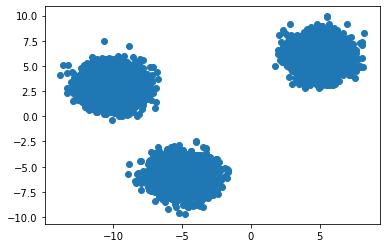

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(data[:,0], data[:,1])

### Initializing The Centroids
----------------------

To initialize the centroids we need to come up with a function that takes a dataset of N points and chooses k of them to be the centroids. This is a naive initialization process compared to k-means++, but for our purposes it will do. We define this function using the [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) function to get the entries of the k different points as shown below 

In [3]:
np.random.choice(N, 3,replace=False)

array([1024,  334, 2585])

We can then write a function to initialize these centroids,

In [97]:
from typing import List

def init_centroids(X: np.array, K: int) -> List[float]:
    N = X.shape[0]
    return X[np.random.choice(N, K,replace=False)]

In [98]:
centroids = init_centroids(data, 3)

The thre initial points for the centroids are,

In [99]:
centroids

array([[ -4.15372408,  -5.98574299],
       [-12.08744716,   2.26857038],
       [ -4.71700728,  -3.80133037]])

We can plot these to see where they are with respsect to the rest of the points,

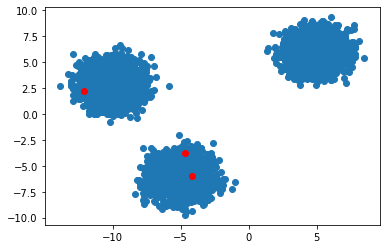

In [100]:
plt.figure()
plt.scatter(data[:,0], data[:,1])
for c in centroids:
    plt.scatter(*c, color="red")

Two of the centroids are look like they are in the same cluster (note due to random seeding you may not get the results). Now lets write a function that assigns each of the points in the dataset to a cluster by finding cluster that each point is closest to.

### Assign Each Point To A Cluster
----------------------

Let's take an example with the first data point and assign it to the value point

In [101]:
point = data[0]
point

array([6.70544592, 5.3291768 ])

We can remind ourselves what the centroids look like

In [102]:
centroids

array([[ -4.15372408,  -5.98574299],
       [-12.08744716,   2.26857038],
       [ -4.71700728,  -3.80133037]])

Now we want to find the distance from the point to each of the centroids. We will use th concept of [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) in NumPy. We can see the shape `point` and `centroids`,

In [103]:
print(f"point.shape = {point.shape}")
print(f"centroids.shape = {centroids.shape}")

point.shape = (2,)
centroids.shape = (3, 2)


Now subtracting the two using broadcasting results in

In [104]:
point - centroids

array([[10.85917   , 11.31491979],
       [18.79289308,  3.06060642],
       [11.4224532 ,  9.13050717]])

We broadcasted the point from a (2,) shape to a (3,2) and then performed elementwise subtraction.

Now we can calculate the distance by using the [norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) from NumPy's numerical linear alebgra module. The use for the norm allows us to use data from arbitrary dimensions! 

In [105]:
dists = np.linalg.norm(point - centroids, axis=1)
dists 

array([15.68276069, 19.04048691, 14.6232212 ])

Now we assign the point to the cluster which is closes usign the [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) function from NumPy.

In [106]:
np.argmin(dists)

2

This means point is closest to cluster 3! We can see this below,

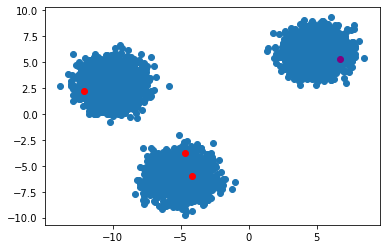

In [107]:
plt.figure()
plt.scatter(data[:,0], data[:,1])
for c in centroids:
    plt.scatter(*c, color="red")

plt.scatter(*point, color='purple')

Now we want to do this for every point in the dataset, we create a new vector called `labels` that is the cluster each point belows to. We use the NumPy empty function to assign an empty array of size N.

In [108]:
labels = np.empty(data.shape[0])

In [109]:
labels

array([ 1.39066528e-309,  9.27116401e-310,  9.27116393e-310, ...,
       -5.37944583e-173, -6.18809309e-173, -7.52440132e-173])

Now we can write function to assign all the points to the cluster it is closest to. We do this for entire dataset using the [enumerate](https://www.geeksforgeeks.org/enumerate-in-python/) function to keep track of the index in the label array while looping over each point in the dataset:

In [110]:
def update_labels(X: np.array, labels: np.array) -> None:
    for i, point in enumerate(X):
        dists = np.linalg.norm(point - centroids, axis=1) # norm along the rows
        labels[i] = np.argmin(dists)

Note this is function edits the labels array by reference instead of returning a new array.

In [111]:
update_labels(data, labels)
labels

array([2., 2., 2., ..., 1., 1., 1.])

### Updating The Centroids
----------------------

The last function we need to write is a function that will update the centroids. The way we update the centroids is by finding the points that belong to a each cluster and the finding the means of those points features to make the new centroid for that cluster. 

We can find all the points that belong to each cluster using the [Masking](https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html). To see how this works we can find all the labeled points that belong to each cluster. For instance we can find which points belong to cluster 0 with the following.  

In [112]:
(labels==0)

array([False, False, False, ..., False, False, False])

Note that this returns a boolean array. We can then using masking to get all points that are in cluster 0

In [113]:
data[labels==0]

array([[-3.15879382, -6.78034205],
       [-3.69193637, -4.86222846],
       [-4.34549342, -6.10490329],
       ...,
       [-3.11331585, -7.40174806],
       [-4.17114828, -6.8429539 ],
       [-4.41680916, -5.76397572]])

We can obtain the centroid values by taking the average along each column which can be calculated with the following,

In [114]:
data[labels==0].mean(axis=0)

array([-4.93733359, -6.32571319])

Writing this as a function that takes in the `dataframe` and `labels` we can write a for loop over the clusters,

In [116]:
def update_centroids(X: np.array, centroids: np.array, labels: np.array, K: int) -> None:
    centroids = np.stack([
                        X[labels==i].mean(axis=0) for i in range(K)
    ])

And can use this to calculate one iteration of the k means algorithm,

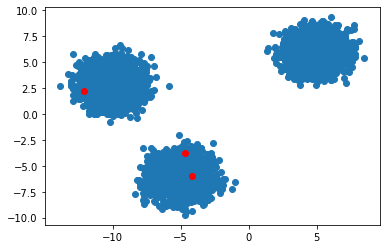

In [117]:
update_centroids(data, centroids, labels, 3)

plt.figure()
plt.scatter(data[:,0], data[:,1])
for c in centroids:
    plt.scatter(*c, color="red")

In [126]:
def fit(X: np.array, K: int, max_iters: int = 100, tol:float = 1e-10) -> List[float]:
    centroids = init_centroids(X=X, K=K)
    labels = np.empty(X.shape[0])

    for _ in range(max_iters):

        # label points belonging to clusters
        prev_centroids = centroids

        # update labels
        update_labels(X=X, labels=labels)

        # update centroids
        update_centroids(X=X, centroids=centroids, labels=labels, K=K)
        
        if np.linalg.norm(prev_centroids - centroids) < tol:
            break
            
    return centroids.copy()

Add 
https://plotly.com/python/v3/gapminder-example/

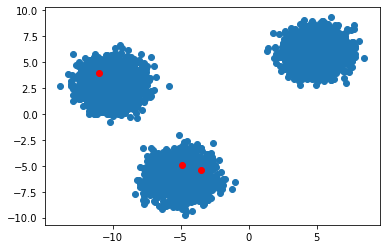

In [127]:
centroids = fit(data, 3)

plt.figure()
plt.scatter(data[:,0], data[:,1])
for c in centroids:
    plt.scatter(*c, color="red")

# Writing a Scikit-Learn compatible estimator <a class="anchor" id="fourth-bullet"></a>
--------------

Now we want to go about creating a Scikit-Learn compatible k-means clustering model so that we can use the built in [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) capability for hyperparameter tuning. We do this by creating a [custom estimator for Scikit-learn](https://scikit-learn.org/stable/developers/develop.html).

In order to so, we need to create a KMeans clustering class that extends the [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) class and since this since clustering algorithm we also extend the [ClusterMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html) class. This uses the concept of inheritence and [abstract base classes or interfaces](https://realpython.com/python-interface/) though not quite so formally.

One thing we change in the implementation is that we allow the number of clusters to be a class member `K` which is passed to the constructor along with the the maximum number of iteration `max_iter`, the tolerance `tol` to terminate the fit method early and a `random_state` to see the choice of datapoints as initial cluster centroids.  The other major changes are mostly to the functions to be private methods of the class and therefore require the `self` parameter and a "_" prefix for all but the `fit` method

In [30]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from __future__ import annotations

class KMeans(BaseEstimator, ClusterMixin):
    
    def __init__(self, 
                 K: int=2, 
                 max_iter: int=10, 
                 random_state: int = 42,
                 tol: float = 1e-6):
        
        self.K = K
        self.max_iter = max_iter
        self.centroids = None
        self.random_state = random_state
        self.tol = tol
        np.random.seed(random_state)
        
    def _init_centroids(self, X: np.array) -> None:
        N = X.shape[0]
        self.centroids = X[np.random.choice(N,self.K,replace=False)]

    def _update_labels(self, X: np.array, labels: np.array) -> None:
        for i, point in enumerate(X):
            dists = np.linalg.norm(point - self.centroids, axis=1) # sum along the rows
            labels[i] = np.argmin(dists)
            
    def _update_centroids(self, X: np.array, labels: np.array) -> None:
        self.centroids = np.stack([
                            X[labels==i].mean(axis=0) for i in range(self.K)
        ])
    
    def fit(self, X: np.array, y: np.array=None) -> KMeans:
        
        self._init_centroids(X)
        labels = np.empty(X.shape[0])
        
        for _ in range(self.max_iter):
            
            # label points belonging to clusters
            prev_centroids = self.centroids

            # update labels
            self._update_labels(X, labels)
            
            # update centroids
            self._update_centroids(X, labels)
            if np.linalg.norm(prev_centroids - self.centroids) < self.tol:
                break
            
        return self
    
    def predict(self, X: np.array) -> np.array:
        labels = np.empty(X.shape[0])
        self._update_labels(X, labels)
        return labels
    
    def score(self, X: np.array, y: np.array=None) -> np.array:
        if y is None:
            y = self.predict(X)
            
        variance = np.sum([np.linalg.norm(X[y==i] - self.centroids[i], axis=1).sum() 
                       for i in range(self.K)]) / X.shape[0]
        return variance
        

In addition to the `fit` function we also have the `predict` method which is required for the BaseEstimator and "Mixin" classes. The predict function is simple as it just calls the `_update_labels` method under the hood. In order for our KMeans class to be compatible with the [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) we need to a `score` method to measure the performance of the object. The `score` function is just the simple [sum of square errors](https://hlab.stanford.edu/brian/error_sum_of_squares.html).

We can now instantiate a 

In [31]:
kmeans = KMeans(3)

kmeans = kmeans.fit(data)

Note that the `fit` function returns itself!

We can see the centroids,

In [32]:
kmeans.centroids

array([[-4.9976344 , -5.99960463],
       [-9.98366889,  3.02528635],
       [ 4.9915725 ,  5.99821863]])

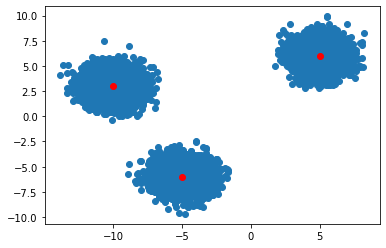

In [33]:
plt.figure()
plt.scatter(data[:,0], data[:,1])
for c in kmeans.centroids:
    plt.scatter(*c, color="red")

And predict any number of values,

In [34]:
kmeans.predict(np.array([10.3242, 5.321]))

array([2., 2.])

Lastly we can find the SSE of the model with the score method,

In [36]:
kmeans.score(data)

1.2548447498057032

# Using the elbow method and Pipelines <a class="anchor" id="fifth-bullet"></a>
-------------------------

We can attempt to compute the appropriate number of clusters *a-posterori* by using the elbow method over various numbers of $k$.


The idea behind the elbow method is that as the number of clusters increases the sum of internal variance or weighted sum of squares decreases rapidly because samples are becoming more and more homogeneous.  At a certain point (the elbow point) the clusters contain relative homogeneous samples and the reduction in weighted sum of squares is less significant as the number of clusters increases.  


In [45]:
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris()
X = iris.data

In [46]:
X.shape

(150, 4)

We can loop over a number of clusters and get the scores. Note the clustering is sensitive to scaling and therefore we use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class before applying the clustering model and therefore need to make a pipeline object!

In [47]:
K_max = 7
scores = [ make_pipeline(StandardScaler(), KMeans(K=k)).fit(X).score(X) for k in range(1,K_max)]

Now we can plot the SSE vs. number of clusters to find the optimal number of clusters:

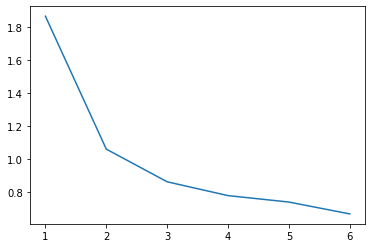

In [48]:
plt.plot(range(1,7), scores)

It's a little hard to tell, but the optimal number of clusters could be 2 or 3, obviously the seperating hyperplanes are not a swell defined as we would like!

We can also now use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) though it doesnt make much sense in this case.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
                ('scaler',StandardScaler()), 
                ('model', KMeans())
            ])

In [54]:
params = {"model__K": [1,2,3,4,5]}

grid = GridSearchCV(estimator=pipeline,
                    param_grid=params)

results = grid.fit(data)

In [56]:
results.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('model', KMeans(K=1))])

Again the results dont make sense, but the main idea is to show how to make a Scikit-Learn compatible estimator!

# Conclusions <a class="anchor" id="sixth-bullet"></a>
-------------------------

References: 
   * https://towardsdatascience.com/k-means-from-scratch-with-numpy-74f79d2b1694
   * https://blog.paperspace.com/speed-up-kmeans-numpy-vectorization-broadcasting-profiling/
   * https://nicholasvadivelu.com/2021/05/10/fast-k-means/